##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l06c01_tensorflow_hub_and_transfer_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# TensorFlow Hub and Transfer Learning

[TensorFlow Hub](http://tensorflow.org/hub)は、使用できる既にトレーニング済みのTensorFlowモデルのオンラインリポジトリです。
これらのモデルは、そのまま使用することも、Transfer Learningに使用することもできます。

転移学習は、既存のトレーニング済みモデルを取得し、それを拡張して追加の作業を行うプロセスです。 これには、可能な出力の異なるセットを取得するために、モデルの大部分を変更せずに残し、最終層を追加および再トレーニングすることが含まれます。

このColabでは、両方を行います。

ここでは、[TensorFlow Module Hub](https://tfhub.dev/)で利用可能なすべてのモデルを見ることができます。

## このColabで扱う概念

1. 予測にTensorFlow Hubモデルを使用します。
2. 犬と猫のデータセットにTensorFlow Hubモデルを使用します。
3. TensorFlow Hubで簡単な転送学習を行います。

このColabを開始する前に、上のメニューから[ランタイム->すべてのランタイムをリセット...]を選択して、Colab環境をリセットする必要があります。


# Imports



このColabでは、TensorFlowの公式リリースにはまだないものを使用する必要があります。 そのため、以下では、TensorFlowの夜間バージョンとTensorFlow Hubを最初にインストールします。

これにより、ColabのTensorFlowのインストールがこのTensorFlowバージョンに切り替わります。 このColabを終了したら、上記のメニューで[ランタイム]-> [すべてのランタイムをリセット...]を選択して、バッチをTensorFlowの最新の安定リリースに切り替える必要があります。 これにより、Colab環境が元の状態にリセットされます。


以前見たいくつかの通常のインポート。 新しいものは、上記でインストールされたtensorflow_hubをインポートしており、このColabはこれを多用します。

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

In [3]:
#!pip install tensorflow_hub

In [4]:
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Part 1: Use a TensorFlow Hub MobileNet for prediction

Colabのこの部分では、トレーニング済みのモデルを取得してKerasにロードし、試してみます。

使用するモデルはMobileNet v2です（ただし、[tfhub.devのtf2互換画像分類URL]のモデルはすべて機能します](https://tfhub.dev/s?q=tf2&module-type=image-classification)。


## Download the classifier

MobileNetモデルをダウンロードして、そこからKerasモデルを作成します。
MobileNetでは、3つのカラーチャネル（RGB）で224 $\times$ 224ピクセルの画像を期待しています。


In [6]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

## Run it on a single image

MobileNetはImageNetデータセットでトレーニングされています。 ImageNetには1000の異なる出力クラスがあり、そのうちの1つは軍服です。
ImageNetの一部ではない軍服を含む画像を取得し、モデルが軍服であると予測できるかどうかを確認します。

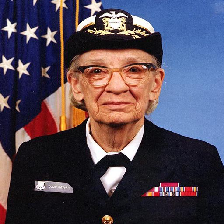

In [7]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [8]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

モデルは常に処理する画像のバッチを必要とします。 そのため、ここではバッチディメンションを追加し、予測のために画像をモデルに渡します。

In [9]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

結果はロジットの1001要素ベクトルであり、画像の各クラスの確率を評価します。

したがって、最上位クラスIDはargmaxで見つけることができます。 しかし、これが実際にどのクラスであるか、特にImageNetデータセット内のそのクラスIDが軍服などを示している場合、どのように知ることができますか

In [10]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

## Decode the predictions

ImageNetデータセット内のpredict_classを確認するには、ImageNetラベルをダウンロードし、モデルが予測した行をフェッチします。

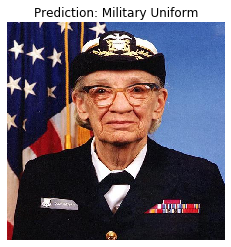

In [11]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

ビンゴ。 私たちのモデルは軍服を正しく予測しました！

# Part 2: Use a TensorFlow Hub models for the Cats vs. Dogs dataset

ここで、完全なMobileNetモデルを使用して、Dogs vs. Catsデータセットでどのように機能するかを確認します。

## Dataset

TensorFlow Datasetsを使用して、Dogs vs Catsデータセットをロードできます。

In [12]:
#!conda install ipywidgets

In [14]:
splits = tfds.Split.ALL.subsplit(weighted=(80, 20))

splits, info = tfds.load('cats_vs_dogs', with_info=True, as_supervised=True, split = splits)

(train_examples, validation_examples) = splits

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dataset cats_vs_dogs downloaded and prepared to C:\Users\hiron\tensorflow_datasets\cats_vs_dogs\2.0.1. Subsequent calls will reuse this data.


Dogs vs. Catsデータセットの画像は、すべて同じサイズではありません。

In [15]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (500, 343, 3)
Image 2 shape: (375, 500, 3)
Image 3 shape: (375, 500, 3)


そのため、すべての画像をMobileNetが期待する解像度（224、224）に再フォーマットする必要があります。

ここの `.repeat（）`と `steps_per_epoch`は必要ありませんが、シャッフルバッファーは一度だけコールドスタートするだけなので、エポックごとに〜15秒節約できます。

In [16]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Run the classifier on a batch of images

`model`オブジェクトは、まだImageNetでトレーニングされた完全なMobileNetモデルであるため、1000の可能な出力クラスがあります。
ImageNetには多くの犬と猫が含まれているため、犬と猫のデータセットで画像を予測できるかどうかを見てみましょう。

In [17]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['Egyptian cat', 'Labrador retriever', 'Egyptian cat', 'malinois',
       'Staffordshire bullterrier', 'Border collie', 'Egyptian cat',
       'tabby', 'dalmatian', 'Siamese cat', 'tabby', 'cairn', 'pug',
       'Persian cat', 'tabby', 'miniature poodle', 'Egyptian cat',
       'Staffordshire bullterrier', 'redbone', 'dalmatian', 'Siamese cat',
       'Italian greyhound', 'Persian cat', 'Pomeranian', 'beagle',
       'bull mastiff', 'Egyptian cat', 'Egyptian cat',
       'miniature pinscher', 'Chihuahua', 'Egyptian cat', 'Persian cat'],
      dtype='<U30')

ラベルは犬と猫の名前と一致しているようです。 Dogs vs Catsデータセットから画像をプロットし、ImageNetラベルをそれらの隣に配置しましょう。

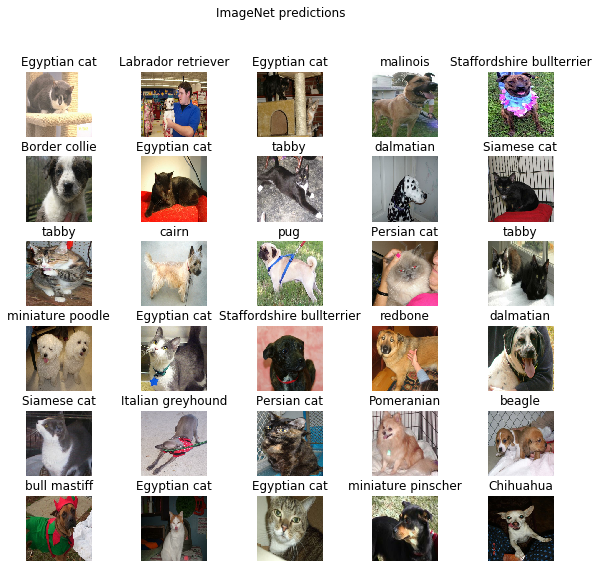

In [18]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Part 3: Do simple transfer learning with TensorFlow Hub

次に、TensorFlow Hubを使用してTransfer Learningを実行しましょう。

転移学習では、すでに訓練されたモデルの一部を再利用し、モデルの最終層または複数の層を変更してから、独自のデータセットでそれらの層を再訓練します。

完全なモデルに加えて、TensorFlow Hubは最後の分類レイヤーなしでモデルを配布します。 これらを使用して、転移学習を簡単に行うことができます。 このコースの後半では、このモデルを使用して、[TensorFlow Lite]（https://www.tensorflow.org/lite)を使用してモバイルデバイスに展開するため、MobileNet v2を引き続き使用します。 任意の[tfhub.devの画像特徴ベクトルURL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2)がここで機能します。

Dogs vs Catsデータセットも引き続き使用するので、このモデルのパフォーマンスを最初から作成したモデルと比較することができます。

TensorFlow Hubの部分モデル（最終的な分類レイヤーなし）を「feature_extractor」と呼んでいることに注意してください。 この用語の理由は、多くのフィーチャを含むレイヤーまで入力をすべて取得することです。 そのため、最終的な確率分布を作成することを除いて、画像のコンテンツを識別する作業の大部分を実行しました。 つまり、画像の特徴を抽出しました。

In [19]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

これを通して画像のバッチを実行し、最終的な形状を見てみましょう。 32は画像の数で、1280はTensorFlow Hubの部分モデルの最後のレイヤーのニューロンの数です。

In [20]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


特徴抽出レイヤーの変数をフリーズして、トレーニングが最終分類レイヤーのみを変更するようにします。

In [21]:
feature_extractor.trainable = False

## Attach a classification head

ここで、ハブ層を「tf.keras.Sequential」モデルでラップし、新しい分類層を追加します。

In [22]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Train the model

最初に `compile`を呼び出し、次に` fit`を呼び出すことにより、他のモデルと同様にこのモデルをトレーニングします。

In [23]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 26s 44ms/step - loss: 0.0597 - accuracy: 0.9798 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/6
582/582 [==============================] - 19s 32ms/step - loss: 0.0307 - accuracy: 0.9897 - val_loss: 0.0308 - val_accuracy: 0.9881
Epoch 3/6
582/582 [==============================] - 19s 32ms/step - loss: 0.0262 - accuracy: 0.9917 - val_loss: 0.0374 - val_accuracy: 0.9869
Epoch 4/6
582/582 [==============================] - 19s 33ms/step - loss: 0.0232 - accuracy: 0.9918 - val_loss: 0.0318 - val_accuracy: 0.9888
Epoch 5/6
582/582 [==============================] - 19s 33ms/step - loss: 0.0189 - accuracy: 0.9936 - val_loss: 0.0298 - val_accuracy: 0.9884
Epoch 6/6
582/582 [==============================] - 19s 33ms/step - loss: 0.0165 - accuracy: 0.9948 - val_loss: 0.0380 - val_accuracy: 0.9853


検証精度が最大97％になることがわかりますが、これは非常に素晴らしいことです。 これは、前のレッスンで作成したモデルを大幅に改善したもので、最大83％の精度を得ることができました。 この違いの理由は、MobileNetが長い間専門家によって慎重に設計され、大規模なデータセット（ImageNet）でトレーニングされたためです。

TensorFlow Hubと同等ではありませんが、KerasでMobileNetを作成する方法を確認できます[こちら](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)。

トレーニングおよび検証の精度/損失グラフをプロットしましょう。

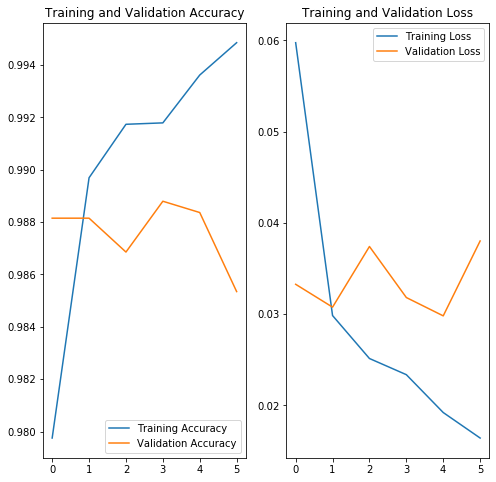

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

ここで少し興味深いのは、実行の開始から終了まで、検証パフォーマンスがトレーニングパフォーマンスよりも優れていることです。

この理由の1つは、検証パフォーマンスはエポックの終わりに測定されるが、トレーニングパフォーマンスはエポック全体の平均値であるということです。

大きな理由は、犬と猫の画像で既に訓練されたMobileNetの大部分を再利用していることです。 トレーニングを行っている間、ネットワークはまだ検証データセットではなく、トレーニング画像で画像増強を実行しています。 これは、検証データセットの通常の画像と比較して、トレーニング画像を分類するのが難しい場合があることを意味します。


## Check the predictions

以前からプロットをやり直すには、まずクラス名の順序付きリストを取得します。

In [25]:
class_names = np.array(info.features['label'].names)
class_names

array(['cat', 'dog'], dtype='<U3')

モデルを介して画像バッチを実行し、インデックスをクラス名に変換します。

In [26]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat', 'cat', 'dog',
       'cat', 'cat', 'dog', 'dog', 'cat', 'cat', 'dog', 'cat', 'dog',
       'dog', 'dog', 'cat', 'dog', 'cat', 'dog', 'dog', 'dog', 'cat',
       'cat', 'dog', 'dog', 'cat', 'cat'], dtype='<U3')

真のラベルと予測ラベルを見てみましょう。

In [27]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0]
Predicted labels:  [0 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 0 0]


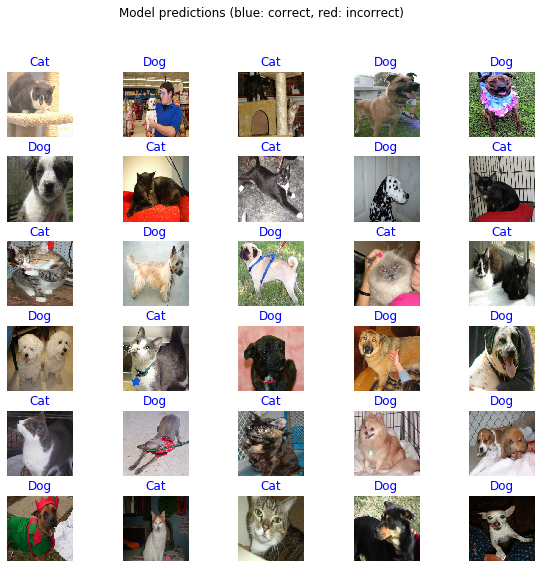

In [28]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

'pwd' は、内部コマンドまたは外部コマンド、
操作可能なプログラムまたはバッチ ファイルとして認識されていません。
